In [ ]:
"""
This is a notebook to perform causal ML analysis with WNV. Since classical modeling techniques were
not sufficient at predicting WNV, I want to try using causal ML to help highlight some features that
are properly tested to *cause* WNV.

NOTE: Performing classical modeling did help to highlight certain features that were important in
the prediction, but these may be based heavily on correlation, not causation. Technically, I could
also go backwards and extract the observations where the SHAP values were most significant, but 
this is a bit of a hassle, and I find causal ML to be more imformative.
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from econml.dml import CausalForestDML
from econml.dr import DRLearner, ForestDRLearner  
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree

RNG_SEED = 42

In [2]:
# Import the data from task 2
train_data = pd.read_pickle("../data/train.pkl")
valid_data = pd.read_pickle("../data/valid.pkl")
test_data = pd.read_pickle("../data/test.pkl")

For this, I will apply a Double Machine Learning (DML) model. This works by combining two ML models,
one to explain the target (in this case, when WNV is present), and another to explain some sort of
treatment (which would be one of the features, such as if rain was present). You compare the 
unexplained part of the target with the unexplained part of the chosen treatment, providing an 
unbiased estimate of the effect on the treatment on WNV being present.

An analogy to help make this sense is like trying to clean off fog on a lens:
- One ML model is used to clean the fog off `Y` (removing what `X`, the cofounders, explains about 
  `Y`)
- Another ML model is used to clean the fog off `T` (removing what `X` explains about `T`)
- Then, you just compare the clean part of `T` and `Y` to measure the true effect

Overall this is a nice way to remove confouding variables (variables that impact both the treatment
and the target)!

-----------

More formally, the two models are combined by calculating the residuals of both initial models, then
fitting a regression using both residuals.

$$\tilde{Y} = \theta \cdot \tilde{T} + \text{noise}$$

where $$\theta$$ is the estimated causal effect of the treatment on the outcome.

This final regression step is **where the two models come together** — by comparing what's left 
(the residuals), DML isolates the causal effect without confounding bias.

However, there are four main assumptions for applying this model:
1. Unconfoundness - All cofounders are accounting for when fitting a DML model. I'll do my best to 
   follow this assumption by including all possible features when fitting each individual DML model.
2. Overlap - No group is perfectly treated or untreated, so we can compare treated/untreated 
   observations with similar covariates. I'll check for this via AUC.
3. Consistency - There is no ambiguity in the treatment labels, which I'll ensure based on how I
   implement the models, but this is an easy assumption to uphold generally.
4. Stable Unit Treatment Value Assumption - The outcome is only affected by the treatment assigned
   to that observation, and not by treatments on other observations. I know this is true based on 
   data preprocessing from task 2.

Assumption 2 must be checked for however. This is done by estimating propensity scores, the 
probability of receiving treatment given the covariates `X`. I'll do this with logistic regression
with AUC scores for categorical cofounders, and with a random forest with R^2 values for continuous 
ones, and show the columns that fit the threshold below:

- If AUC is roughly equal to 0.5, the treatment is not very predictable on X, meaning there is 
   overlap.
- AUC values greater than ~0.7 or less than ~0.3, and R^2 values less than ~0.8 imply that the model 
can (almost) perfectly predict treatment, suggesting poor overlap, meaning the assumption is 
violated.

In [4]:
# Concatenate train_data, valid_data, and test_data into one DataFrame
# For causal ML, since there is no "prediction", there is no need to have our standard data split
df = pd.concat([train_data, valid_data, test_data], ignore_index=True)

In [ ]:
# Define outcome and features
outcome_col = 'WnvPresent'
excluded_cols = [outcome_col]
feature_cols = [col for col in df.columns if col not in excluded_cols]

# Storage for valid treatments
valid_treatments_info = []

# Loop over all features as potential treatments
for treatment_col in feature_cols:
    X = df.drop(columns=[outcome_col, treatment_col])

    # Ensure all feature columns are numeric for scaling
    X_numeric = X.select_dtypes(include=np.number)
    T = df[treatment_col].values

    # Scale features
    X_scaled = StandardScaler().fit_transform(X_numeric)

    # Fit the appropriate model based on the treatment type
    try:
        # Case 1: Binary Treatment (use Logistic Regression and AUC)
        if df[treatment_col].nunique() == 2:
            ps_model = LogisticRegression(max_iter=2000, random_state=RNG_SEED)
            ps_model.fit(X_scaled, T)
            propensity_scores = ps_model.predict_proba(X_scaled)[:, 1]
            score = roc_auc_score(T, propensity_scores)
            metric = 'AUC'
            # Apply overlap threshold rule: AUC should be not too close to 1 or 0
            if 0.3 < score < 0.7:
                valid_treatments_info.append({'Treatment': treatment_col, 'Metric': metric, 'Score': score})

        # Case 2: Continuous Treatment (use Regressor and R-squared)
        elif pd.api.types.is_numeric_dtype(df[treatment_col]):
            ps_model = RandomForestRegressor(n_estimators=100, random_state=RNG_SEED)
            ps_model.fit(X_scaled, T)
            predictions = ps_model.predict(X_scaled)
            score = r2_score(T, predictions)
            metric = 'R2'
            # Apply overlap threshold rule: R2 should not be too close to 1
            if score < 0.8:
                valid_treatments_info.append({'Treatment': treatment_col, 'Metric': metric, 'Score': score})

    except Exception as e:
        print(f"Error fitting model for {treatment_col}: {e}")

# Create DataFrame of valid treatments
valid_treatment_df = pd.DataFrame(valid_treatments_info)
if not valid_treatment_df.empty:
    valid_treatment_df.sort_values("Score", inplace=True)
    valid_treatment_df.reset_index(drop=True, inplace=True)

print(valid_treatment_df)

     Treatment Metric    Score
0         Cool     R2  0.15000
1      Sunrise     R2  0.21000
2    ResultDir     R2  0.24000
3         Heat     R2  0.33000
4           HZ    AUC  0.43996
5  day_of_year     R2  0.45000
6           RA    AUC  0.47333
7           TS    AUC  0.50287
8           BR    AUC  0.55705


These are the remaining features/variables that we can properly test individually as treatment. I'll
filter `df` to just these columns with `WnvPresent`:

In [6]:
df = df[list(valid_treatment_df["Treatment"]) + ["WnvPresent"]]
print(df)

       ResultDir   Sunrise  RA  Cool  BR  HZ  TS  Heat  day_of_year  \
0           17.0  4.350000   0  10.5   1   1   0   0.0          149   
1           17.0  4.350000   0  10.5   1   1   0   0.0          149   
2           17.0  4.350000   0  10.5   1   1   0   0.0          149   
3           17.0  4.350000   0  10.5   1   1   0   0.0          149   
4           17.0  4.350000   0  10.5   1   1   0   0.0          149   
...          ...       ...  ..   ...  ..  ..  ..   ...          ...   
10408       34.0  5.783333   1   0.0   0   0   0  13.0          273   
10409       34.0  5.783333   1   0.0   0   0   0  13.0          273   
10410       34.0  5.783333   1   0.0   0   0   0  13.0          273   
10411       34.0  5.783333   1   0.0   0   0   0  13.0          273   
10412       34.0  5.783333   1   0.0   0   0   0  13.0          273   

       WnvPresent  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
10408  

Now, the DML model can be built with our data. I'll just use LGBM models as the two models to 
support the DML. I chose to use a CausalForestDML model since this is suited for showing causality
on a binary outcome. This is effectively a random forest model suited for causality, where each
split aims to maximize the difference in the treatment effect, allowing direct estimation of
heterogenous effects defined by corresponding covariates.

Note this novice pipeline does save some extra data, which is used for further analysis.

In [18]:
# Store honest tree models and visualizations
honest_tree_models = []
honest_tree_figs = []

RNG_SEED = 42

# Specifying target and feature columns
target_col   = "WnvPresent"
feature_cols = [c for c in df.columns if c != target_col]

# Empty array to store final results into
results = []

# Empty array to store ITE plots
ite_plots = []

# Loop through each feature column to apply as treatment individually, with all other columns
# other than WnvPresent as possible covariates; WnvPresent is the outcome
for feat in feature_cols:

    # Specify the cofounding columns
    control_cols = [c for c in feature_cols if c != feat]
    if not control_cols:
        raise ValueError(f"{feat}: no control variables available")

    # Drop rows with missing values, just in case there are some
    data = df.dropna(subset=[target_col, feat] + control_cols)

    # Setup Y, T, and X (W handles possible heterogenous treatment effects across groups, which I'll
    # handle with the covariates)
    Y = data[target_col].astype(int).values          
    T = data[feat].values
    W = data[control_cols].values   
    X = W                                                         

    # Specify whether treatment is a binary column or continuous
    uniq = np.unique(T)
    is_binary = len(uniq) == 2 and np.all(np.isin(uniq, [0, 1]))

    # Initialize the two models used in DML
    # TODO: Perhaps one could try and do hyperparameter tuning on these models, but since I am only
    # trying to find some general causal patterns, I don't think its needed here
    model_y = LGBMClassifier(verbose=-1)                 
    model_t = LGBMClassifier(verbose=-1) if is_binary else LGBMRegressor(verbose=-1)

    # Fit the DML; A CausalForestDML is used here to handle our binary outcome of WNV being present
    learner = CausalForestDML(
        model_y=model_y,
        model_t=model_t,
        discrete_outcome=True,          
        discrete_treatment=is_binary,   
        n_estimators=100,
        random_state=RNG_SEED
    )
    learner.fit(Y=Y, T=T, X=X, W=W)

    # Compute the average/individual treatment effect for each feature; ATE/ITE for short,
    # and store results in list
    if is_binary:
        ite = learner.effect(X)
        ate = learner.ate_.item()       
    else:
        ite = learner.effect(X)
        ate = ite.mean()  
    results.append({"feature": feat, "ATE": ate})
    ite_plots.append({"feature": feat, "ite_values": ite})

    # Fit a decision tree regressor, predicting the ITEs based on the covariates/heterogeneous
    # treatment effects; Store results in list
    # A standard decision tree is used over a LGBMRegressor since it is much easier to interpret
    # a single tree vs. an ensemble

    # TODO: Could try and finetune hyperparameters when fitting this model, but given this is mainly
    # to help highlight treatment effects instead of going for maximum prediction accuracy, this is
    # likely not needed
    # Hyperparameters are for a simple tree structure to help interpretability
    tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=50, random_state=RNG_SEED)
    tree.fit(W, ite)  
    honest_tree_models.append({"feature": feat, "tree_model": tree})

# Build final results DataFrame
results_df = (
    pd.DataFrame(results)
      .reset_index(drop=True)
)
print(results_df)

       feature       ATE
0           RA  0.108588
1           BR  0.106384
2           HZ  0.122440
3           TS  0.091447
4    ResultDir -0.000591
5      Sunrise  0.002542
6         Cool  0.086928
7         Heat  0.083541
8  day_of_year  0.000759


It's clear that 6 out of the 9 features treated as individual treatments, do have a somewhat 
significant impact when looking at the overall impact. The intepretation for each treatment, 
averaged out, can be viewed as follows, with an explanation for each feature:


* **HZ (Haze):**
    * **Meaning:** Whether the weather on a given day was recorded as hazy by NOAA.
    * **ATE Interpretation:** Its presence is associated with a **12.2 percentage point increase** 
    in the probability of WNV.

* **RA (Rain):**
    * **Meaning:** Whether the weather on a given day was rainy as recorded by NOAA.
    * **ATE Interpretation:** Its presence is associated with a **10.9 percentage point increase** 
    in the probability of WNV, likely by creating mosquito breeding grounds.

* **BR (Mist):**
    * **Meaning:** Whether the weather indicated mist (e.g. humidity in the air) as recorded by 
    NOAA.
    * **ATE Interpretation:** Its presence is associated with a **10.6 percentage point increase** 
    in the probability of WNV.

* **TS (Thunderstorm):**
    * **Meaning:** Whether the weather recorded a thunderstorm on a given day as recorded by NOAA.
    * **ATE Interpretation:** Its presence is associated with a **9.1 percentage point increase** in 
    the probability of WNV.

* **Cool (Cooling Degree-Days):**
    * **Meaning:** A measure of how much hotter the daily temperature was above 65 degrees 
    Fahrenheit, as a measurement for how much energy is needed for cooling.
    * **ATE Interpretation:** Each additional degree the average daily temperature exceeds 65°F
    is associated with an **8.7 percentage point increase** in the probability of WNV.

* **Heat (Heating Degree-Days):**
    * **Meaning:** A measure of how much cooler the daily temperature was above 65 degrees 
    Fahrenheit, as a measurement for how much energy is needed for heating.
    * **ATE Interpretation:** Each additional degree the average daily temperature is below 65°F 
    is associated with an **8.4 percentage point increase** in the probability of WNV.

* **Sunrise:**
    * **Meaning:** The time of sunrise, in 24H time.
    * **ATE Interpretation:** Each additional minute later that sunrise occurs is associated with a 
        negligible **0.3 percentage point increase** in the probability of WNV.

* **day_of_year:**
    * **Meaning:** The sequential day of the year (1-365).
    * **ATE Interpretation:** Each day later in the year is associated with a negligible 
        **0.08 percentage point increase** in the probability of WNV.

* **ResultDir (Resultant Wind Direction):**
    * **Meaning:** The average wind direction over 24 hours, measured in degrees (1-360) in 10 
    degree units.
    * **ATE Interpretation:** Each additional 10 degrees in wind direction (clockwise) is associated 
    with a **0.06 percentage point decrease** in the probability of WNV.

Overall, many weather conditions directly contribute to a significant impact to WNV, with features 
like Sunrise and day of year not having much of a noticable impact, which is what is expected.

Though, these are just the average effects. So, I display a subplot of the individual effects for 
each observation below for a better understanding.

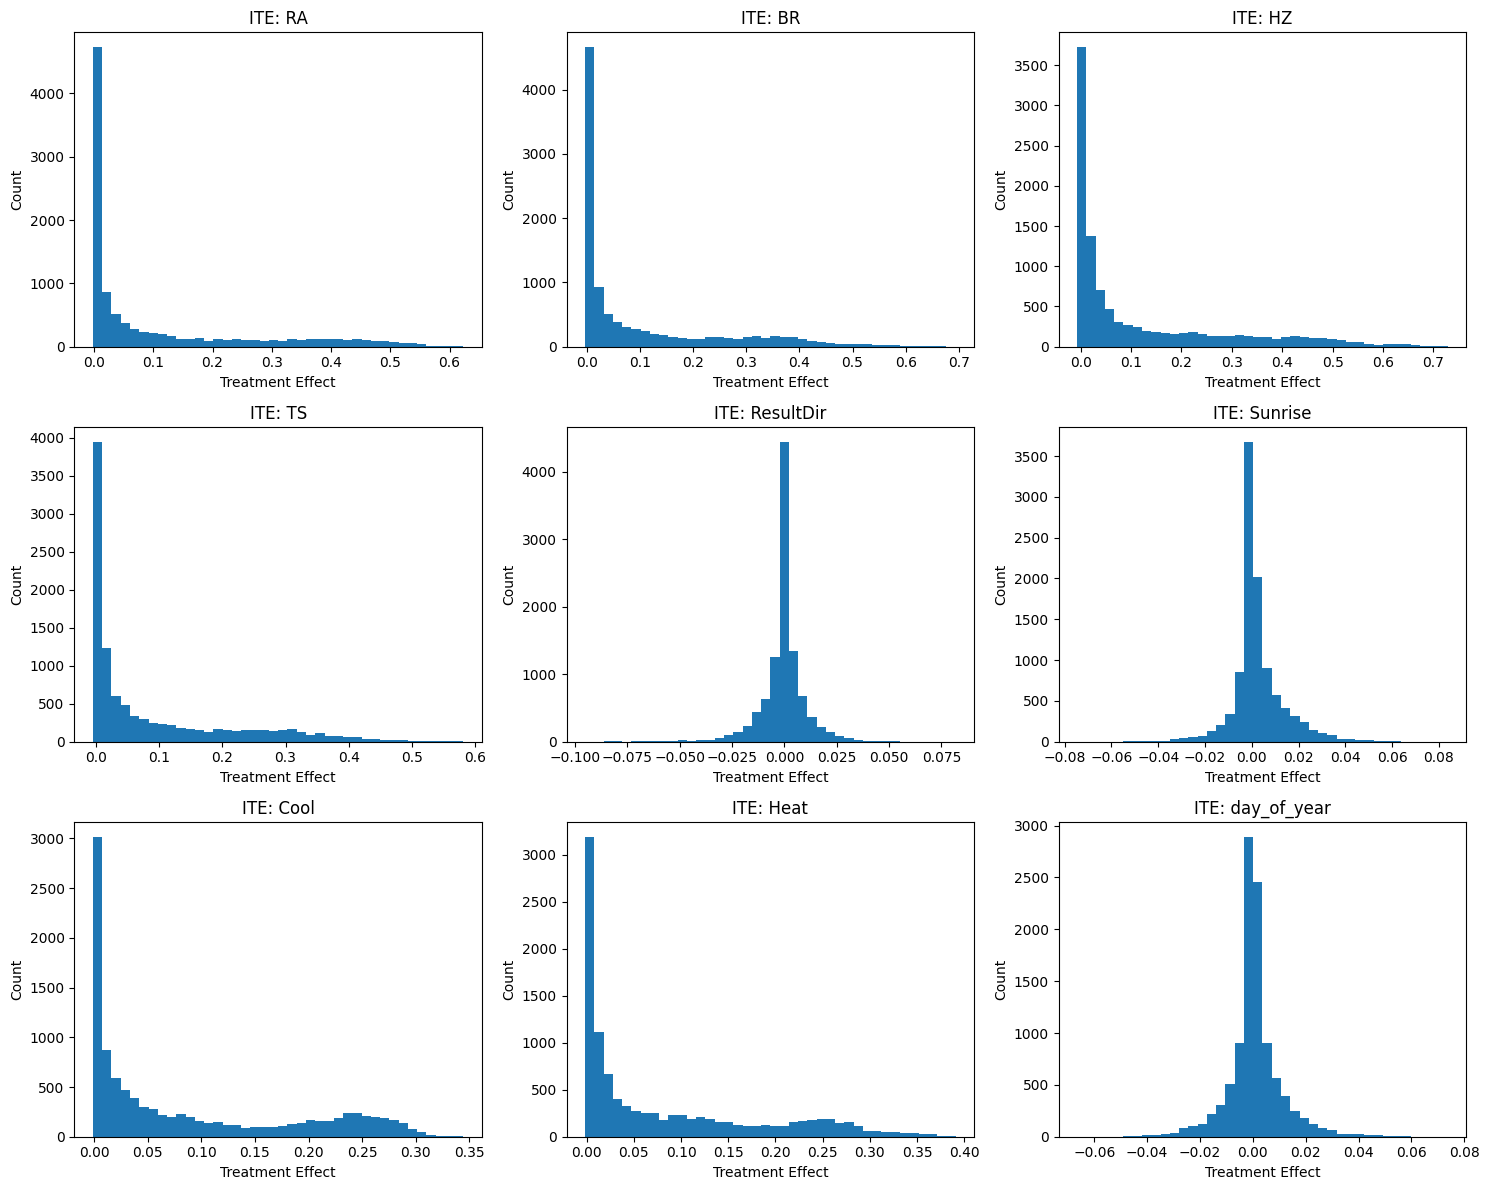

In [19]:
# Plot subplot of ITEs

# Setting up the subgrid
n = len(ite_plots)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

# Loop through ite_plots and get the neccessary data to plot each histogram
for idx, plot_dict in enumerate(ite_plots):
    ax = axes[idx]
    ax.hist(plot_dict['ite_values'], bins=40)
    ax.set_title(f"ITE: {plot_dict['feature']}")
    ax.set_xlabel("Treatment Effect")
    ax.set_ylabel("Count")

# In case of any leftover plots, set them to be blank
for ax in axes[len(ite_plots):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

This highlights that for most weather treatments (other than wind direction), many do increase the 
risk for WNV under certain circumstances (highlighting high levels of hetereogeneity as hinted with
the right skewed distribution).
Meanwhile, the other treatments have at most, a mild average effect, with the 
influence being balanced (as hinted with the approximate normal distributions centered around a 0
treatment effect).

I can go one further step. Thus far, this only highlights individual ITEs, but of course, it should
not be surprising that we may have interacting treatments such that a combination of two or more
lead to a significant impact on WNV. So, I go ahead and plot the "honest" trees that were saved
in the pipeline when fitting the DML models. These are effectively just decision trees, where I try
to predict the ITE values from each treatment based on the possible cofounding variables from each
treatment run. Then, by viewing the splits in each tree for each set of ITEs for each treatment, 
this can show which other cofounding variables were important for the ITEs (in other words, this
will highlight *conditional* average treatment effects)!

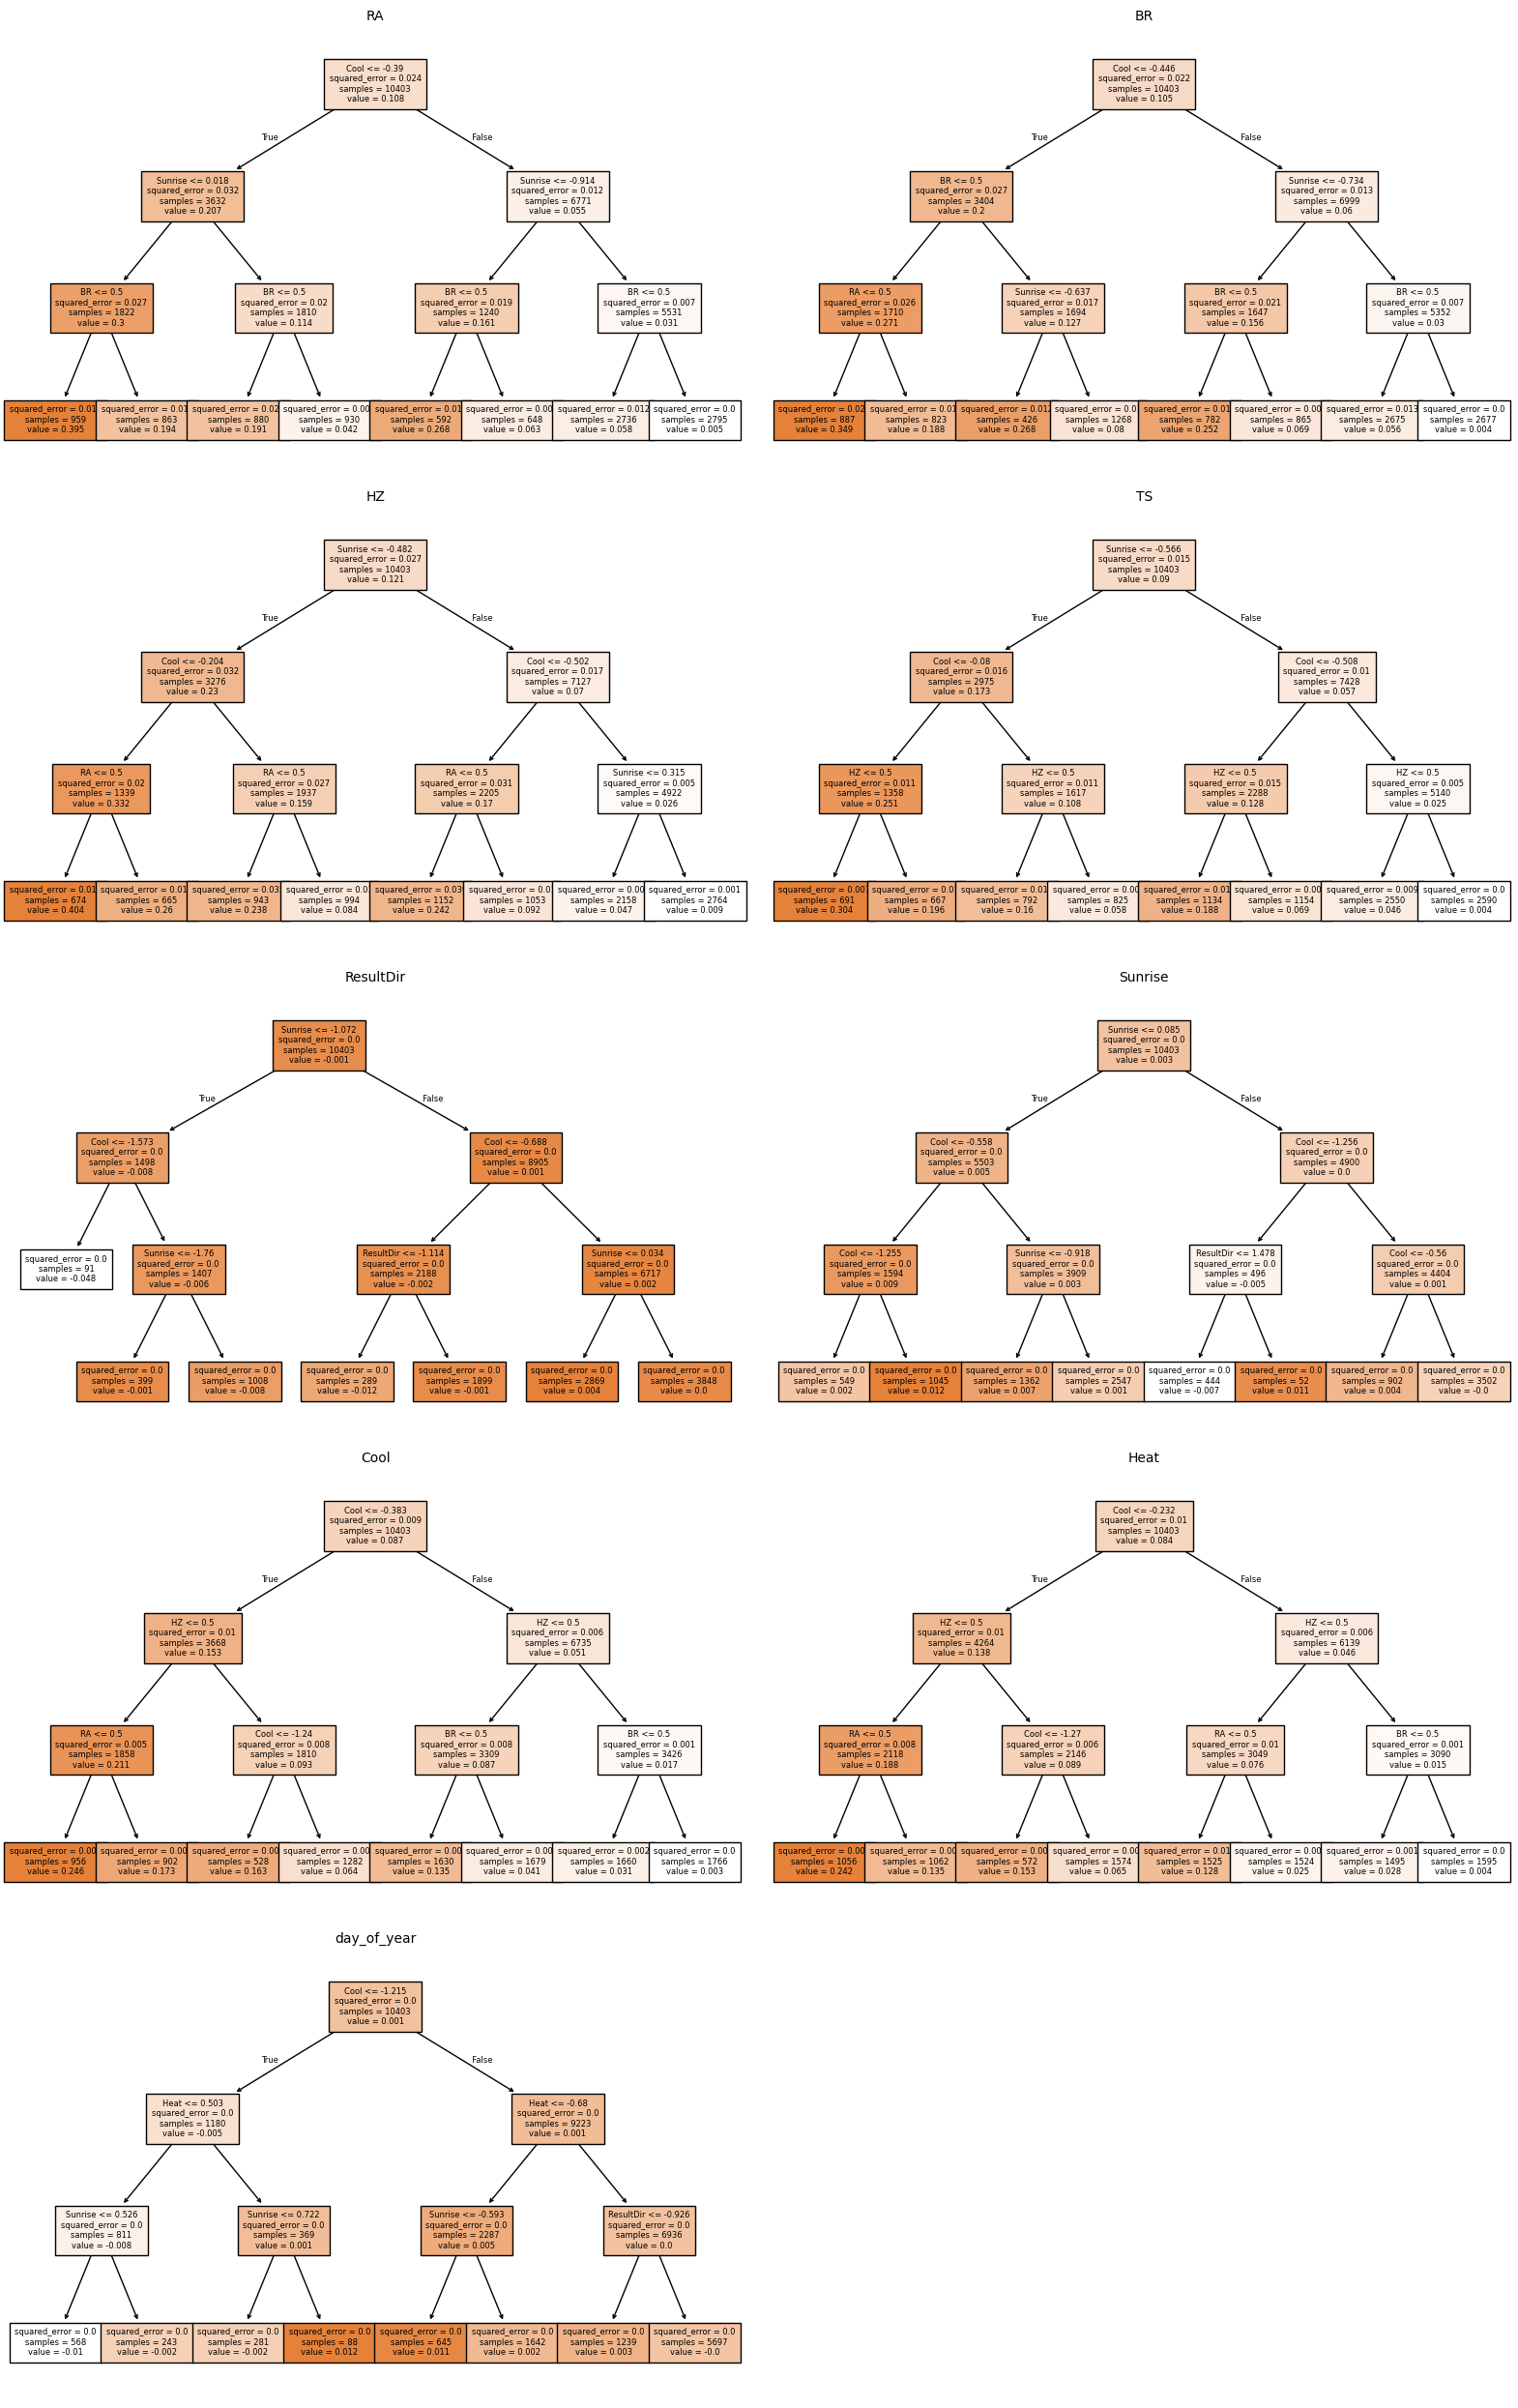

In [24]:
# Plot the "honest" trees 

# Set grid layout
n = len(honest_tree_models)
cols = 2
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 8, rows * 5))
axes = axes.flatten()

# Re-plot each honest tree
for i, entry in enumerate(honest_tree_models):
    tree = entry["tree_model"]
    feat_name = entry["feature"]
    ax = axes[i]
    plot_tree(tree, feature_names=control_cols, filled=True, ax=ax, fontsize=6)
    ax.set_title(f"{feat_name}", fontsize=10)

# Hide any extra axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


The following general insights can be derived based on this plot, especially for paths that lead
to a high `value` (the ITEs):

1. Seasonality is the most important factor (based on covariates like `day_of_year` and `Sunrise`). 
   Not too surprising, the ITEs are neglible early in the year and amplify in the hot summer months.

2. ITEs are impacted next by heat. This shows that many treatment effects are amplified after
   seasonality, when combined with high temperatures and humidity.

3. Weather conditions, like rain and thunderstorms, supress the final ITE. Even when other factors
   that normally would impact ITEs greatly are present, such weather muddles these effects.

These insights are not too surprising, but it's good to validate these insights with causality!

As a final note, note that this analysis is quite limited. Not only is there a lack of data for some
years (which may hide important patterns), but only a few features in the original dataset were 
suited to fit the assumptions needed to do causal analysis. More data may allow more features to be
included. In a similar manner, there may be other covariates in the data that are not accounted for,
which may skew the data.